<a href="https://colab.research.google.com/github/PRAN20/AlexNet/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Header Files**

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu")

# **Generating Class**

In [2]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)

In [3]:
model = AlexNet()
model = model.to(device)

# **Extracting DataBase**

In [4]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2022-02-12 06:46:51--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.128
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  65.2MB/s    in 21s     

2022-02-12 06:47:12 (65.6 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [8]:
!unzip "/content/celeba.zip" -d "Data"

Streaming output truncated to the last 5000 lines.
 extracting: Data/img_align_celeba/197600.jpg  
 extracting: Data/img_align_celeba/197601.jpg  
 extracting: Data/img_align_celeba/197602.jpg  
 extracting: Data/img_align_celeba/197603.jpg  
 extracting: Data/img_align_celeba/197604.jpg  
 extracting: Data/img_align_celeba/197605.jpg  
 extracting: Data/img_align_celeba/197606.jpg  
 extracting: Data/img_align_celeba/197607.jpg  
 extracting: Data/img_align_celeba/197608.jpg  
 extracting: Data/img_align_celeba/197609.jpg  
 extracting: Data/img_align_celeba/197610.jpg  
 extracting: Data/img_align_celeba/197611.jpg  
 extracting: Data/img_align_celeba/197612.jpg  
 extracting: Data/img_align_celeba/197613.jpg  
 extracting: Data/img_align_celeba/197614.jpg  
 extracting: Data/img_align_celeba/197615.jpg  
 extracting: Data/img_align_celeba/197616.jpg  
 extracting: Data/img_align_celeba/197617.jpg  
 extracting: Data/img_align_celeba/197618.jpg  
 extracting: Data/img_align_celeba/19

# **Processing DataBase**

In [10]:
root = 'Data/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


# **Declaring Variable**

In [13]:
df = pd.read_csv("list_attr_celeba.csv")
df = df[['File_name', 'Smiling']]

In [14]:
!rm -rf data
!mkdir data && mkdir data/smile && mkdir data/no_smile

# **Chategorising vARIABLE**

In [17]:
s0 = 0
s1 = 0

num = 1500

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Smiling'] == 1:
      s0 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['File_name'], 'data/smile/' + i_row['File_name'])
  
  if s1 < num:
    if i_row['Smiling'] == -1:
      s1 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['File_name'], 'data/no_smile/' + i_row['File_name'])
  
  if s0 == num and s1 == num:
    break

In [18]:
img_list = os.listdir('data/smile/')
img_list.extend(os.listdir('data/no_smile/'))

In [19]:
print("Images: ", len(img_list))

Images:  3000


In [20]:
!rm -rf 'data/.ipynb_checkpoints/'

In [21]:
transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor()
          ])

batch_size = 64
celeba_data = datasets.ImageFolder('data', transform=transform)

In [22]:
print(celeba_data.classes)
print(len(celeba_data))

['no_smile', 'smile']
3000


# **Training Model**

In [23]:
train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [24]:
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [25]:
print(train_data_size)
print(test_data_size)

2250
750


In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# **Epochs = 10, Calculating train_loss**

In [27]:
epochs = 10
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

Epoch: 0 | Train Loss: 0.6938646336396536
Epoch: 1 | Train Loss: 0.6936574015352461
Epoch: 2 | Train Loss: 0.6948659883605109
Epoch: 3 | Train Loss: 0.6934189250071844
Epoch: 4 | Train Loss: 0.6902329557471805
Epoch: 5 | Train Loss: 0.6563470164934794
Epoch: 6 | Train Loss: 0.5702031991548009
Epoch: 7 | Train Loss: 0.4989662344257037
Epoch: 8 | Train Loss: 0.4766063085860676
Epoch: 9 | Train Loss: 0.4517214828067356


# **Plotting Graph**

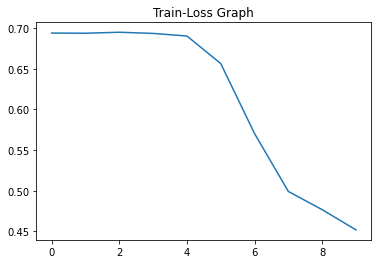

In [29]:
plt.title('Train-Loss Graph')
plt.plot(train_loss)